In [1]:
import pandas as pd
from six.moves import cPickle
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

# 1. Data Loading

Loading the review data file and business file

In [3]:
df_full = pd.read_csv('yelp_academic_dataset_review.csv')

C:\Users\QuangLocLe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_full.head()

,business_id,cool,date,funny,review_id,stars,text,type,useful,user_id
0,2aFiy99vNLklCx3T_tGS9A,0,2011-10-10,0,NxL8SIC5yqOdnlXCg18IBg,5.0,If you enjoy service by someone who is as comp...,review,0.0,KpkOkG6RIf4Ra25Lhhxf1A
1,2aFiy99vNLklCx3T_tGS9A,0,2010-12-29,0,pXbbIgOXvLuTi_SPs1hQEQ,5.0,After being on the phone with Verizon Wireless...,review,1.0,bQ7fQq1otn9hKX-gXRsrgA
2,2aFiy99vNLklCx3T_tGS9A,0,2011-04-29,0,wslW2Lu4NYylb1jEapAGsw,5.0,Great service! Corey is very service oriented....,review,0.0,r1NUhdNmL6yU9Bn-Yx6FTw
3,2LfIuF3_sX6uwe-IR-P0jQ,1,2014-07-14,0,GP6YEearUWrzPtQYSF1vVg,5.0,Highly recommended. Went in yesterday looking ...,review,0.0,aW3ix1KNZAvoM8q-WghA3Q
4,2LfIuF3_sX6uwe-IR-P0jQ,0,2014-01-15,0,25RlYGq2s5qShi-pn3ufVA,4.0,I walked in here looking for a specific piece ...,review,0.0,YOo-Cip8HqvKp_p9nEGphw


In [5]:
df_bus = pd.read_csv('yelp_academic_dataset_business.csv')

In [6]:
print("Columns in business data file are:")
for i in df_bus.columns:
    print(i)

Columns in business data file are:
address
attribute_AcceptsInsurance
attribute_AgesAllowed
attribute_Alcohol
attribute_Ambience_casual
attribute_Ambience_classy
attribute_Ambience_divey
attribute_Ambience_hipster
attribute_Ambience_intimate
attribute_Ambience_romantic
attribute_Ambience_touristy
attribute_Ambience_trendy
attribute_Ambience_upscale
attribute_BYOB
attribute_BYOBCorkage
attribute_BestNights_friday
attribute_BestNights_monday
attribute_BestNights_saturday
attribute_BestNights_sunday
attribute_BestNights_thursday
attribute_BestNights_tuesday
attribute_BestNights_wednesday
attribute_BikeParking
attribute_BusinessAcceptsBitcoin
attribute_BusinessAcceptsCreditCards
attribute_BusinessParking_garage
attribute_BusinessParking_lot
attribute_BusinessParking_street
attribute_BusinessParking_valet
attribute_BusinessParking_validated
attribute_ByAppointmentOnly
attribute_Caters
attribute_CoatCheck
attribute_Corkage
attribute_DietaryRestrictions_dairy-free
attribute_DietaryRestriction

# 2. Data Exploration, Data Cleaning and Matrix Building 

## 2.a. Number of businesses in each city:

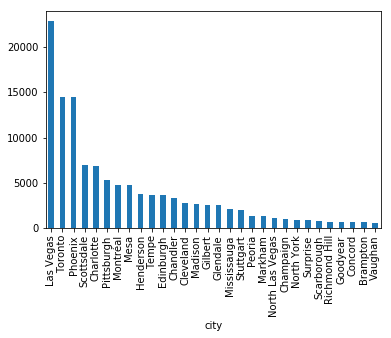

In [7]:
df_bus_groups = df_bus.groupby('city').count()
df_bus_city = df_bus_groups['name']
df_bus_city_sorted = df_bus_city.sort_values(ascending = False)
df_bus_city_sorted[:30].plot(kind = 'bar')

## 2.b. Different Type of Businesses and their Count:

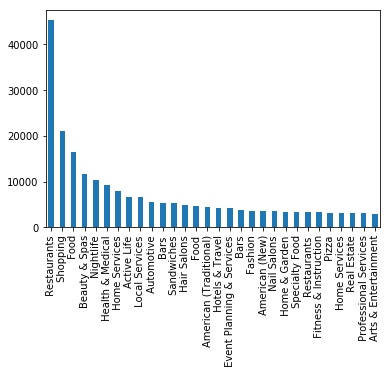

In [8]:
uniq_cat_dict = {}
for i in df_bus.categories:
    cat = str(i).split(',')
    for j in cat:
        if j not in uniq_cat_dict.keys():
            uniq_cat_dict[j] = 1
        else:
            uniq_cat_dict[j] += 1
uniq_cat_series = pd.Series(uniq_cat_dict)
uniq_cat_series.sort_values(ascending = False, inplace = True)
uniq_cat_series[:30].plot(kind = 'bar')

## 2.c. Business and City Ordered pairs and their count:

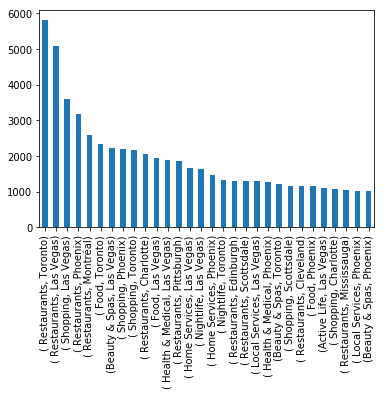

In [9]:
business_city = {}
n = len(df_bus)
for i in range(n):
    k1 = str(df_bus.categories.iloc[i]).split(',')
    k2 = df_bus.city.iloc[i]
    for j in k1:
        k = (j,k2)
        if k not in business_city.keys():
            business_city[k] = 1
        else:
            business_city[k] += 1
business_city_series = pd.Series(business_city)
business_city_series.sort_values(ascending = False, inplace = True)
business_city_series[:30].plot(kind = 'bar')

## Inferences from 2.a, 2.b and 2.c

It can be seen that most of the businesses listed on the Yelp are Restaurants, Shopping places and Recreational Centers. For this given data set (obtained from Yelp's Website), top cities with maximum businesses are Las Vegas, Phoenix, and Toronto.

## 2.d. Cleaning the review data

Dropping the unwanted columns like 'text': review text, 'useful': Number of people rated it useful, 'date',etc.
The columns left are 'user_id', 'business_id' and 'stars'.

In [10]:
df_reduced = df_full.drop(['text','useful','cool', 'date', 'funny'], axis = 1)
df_reduced.head()

,business_id,review_id,stars,type,user_id
0,2aFiy99vNLklCx3T_tGS9A,NxL8SIC5yqOdnlXCg18IBg,5.0,review,KpkOkG6RIf4Ra25Lhhxf1A
1,2aFiy99vNLklCx3T_tGS9A,pXbbIgOXvLuTi_SPs1hQEQ,5.0,review,bQ7fQq1otn9hKX-gXRsrgA
2,2aFiy99vNLklCx3T_tGS9A,wslW2Lu4NYylb1jEapAGsw,5.0,review,r1NUhdNmL6yU9Bn-Yx6FTw
3,2LfIuF3_sX6uwe-IR-P0jQ,GP6YEearUWrzPtQYSF1vVg,5.0,review,aW3ix1KNZAvoM8q-WghA3Q
4,2LfIuF3_sX6uwe-IR-P0jQ,25RlYGq2s5qShi-pn3ufVA,4.0,review,YOo-Cip8HqvKp_p9nEGphw


## 2.e. Merging the business data with the review data

Merging the business data and the review data on the 'business_id'. Information like 'city' of the business and 'categories' of the business were taken from the business data file.

In [11]:
df_merged = df_reduced.merge(df_bus[['city','categories', 'business_id']], how = 'outer', on= 'business_id')
df_merged.head()

,business_id,review_id,stars,type,user_id,city,categories
0,2aFiy99vNLklCx3T_tGS9A,NxL8SIC5yqOdnlXCg18IBg,5.0,review,KpkOkG6RIf4Ra25Lhhxf1A,Phoenix,"IT Services & Computer Repair, Local Services,..."
1,2aFiy99vNLklCx3T_tGS9A,pXbbIgOXvLuTi_SPs1hQEQ,5.0,review,bQ7fQq1otn9hKX-gXRsrgA,Phoenix,"IT Services & Computer Repair, Local Services,..."
2,2aFiy99vNLklCx3T_tGS9A,wslW2Lu4NYylb1jEapAGsw,5.0,review,r1NUhdNmL6yU9Bn-Yx6FTw,Phoenix,"IT Services & Computer Repair, Local Services,..."
3,2LfIuF3_sX6uwe-IR-P0jQ,GP6YEearUWrzPtQYSF1vVg,5.0,review,aW3ix1KNZAvoM8q-WghA3Q,Phoenix,"Antiques, Home & Garden, Home Decor, Shopping"
4,2LfIuF3_sX6uwe-IR-P0jQ,25RlYGq2s5qShi-pn3ufVA,4.0,review,YOo-Cip8HqvKp_p9nEGphw,Phoenix,"Antiques, Home & Garden, Home Decor, Shopping"


In [12]:
df_cleaned = df_merged.dropna()

## 2.f. Getting the top Business and City for which highest number of reviews are obtained

In [26]:
def topm_num_reviews_for_city_n_biz(df,m):
    business_city_count = {}
    n = len(df)
    for i in range(n):
        k1 = str(df.categories.iloc[i]).split(',')
        k2 = df.city.iloc[i]
        for j in k1:
            k = (j,k2)
            if k not in business_city_count.keys():
                business_city_count[k] = 1
            else:
                business_city_count[k] += 1
    business_city_count_series = pd.Series(business_city_count)
    business_city_count_series.sort_values(ascending = False, inplace = True)
    return business_city_count_series

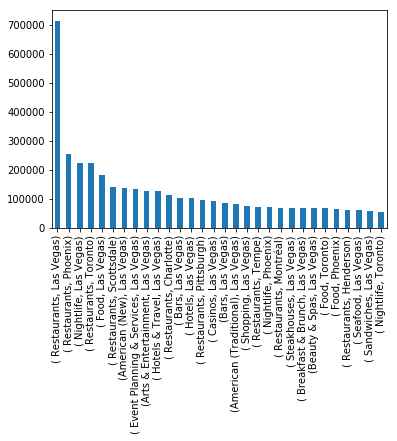

In [27]:
review_business_city = topm_num_reviews_for_city_n_biz(df_cleaned,10)
review_business_city[:30].plot(kind = 'bar')

In [28]:
rest_phoenix_reviews = df_cleaned[(df_cleaned.city == 'Phoenix') & (df_cleaned.categories.str.contains('.Restaurant.', case= False))]
rest_phoenix_reviews.shape

(252976, 7)

In [29]:
rest_toronto_reviews = df_cleaned[(df_cleaned.city == 'Toronto') & (df_cleaned.categories.str.contains('.Restaurant.', case= False))]
rest_toronto_reviews.shape

(223717, 7)

In [30]:
def get_clean_df(df, min_user_review = 30, min_res_review = 0, cols = ['user_id', 'business_id', 'stars']):
    '''Cleans the df and gets rid of the unwanted cols and also allows to filter the user and business based on the min number of reviews received'''
    df_new = df[cols]
    df_new.dropna(axis = 0, how = 'any', inplace = True)
    df_new[cols[1]+'_freq'] = df_new.groupby(cols[1])[cols[1]].transform('count')
    df_clean = df_new[df_new[cols[1]+'_freq']>=min_res_review]
    df_clean[cols[0]+'_freq'] = df_clean.groupby(cols[0])[cols[0]].transform('count')
    df_clean_2 = df_clean[df_clean[cols[0]+'_freq']>=min_user_review]
    return df_clean_2

In [31]:
def get_sparsity(sparse_matrix):
    return 1 - sparse_matrix.nnz/(sparse_matrix.shape[0]*sparse_matrix.shape[1])

In [33]:
def get_sparse_matrix(df):
    '''Converts the df into a sparse ratings matrix'''
    unique_users = list(df['user_id'].unique())
    unique_bus = list(df['business_id'].unique())
    data = df['stars'].tolist()
    row = df['user_id'].astype('category', categories=unique_users).cat.codes
    col = df['business_id'].astype('category', categories=unique_bus).cat.codes
    sparse_matrix = csr_matrix((data, (row, col)), shape=(len(unique_users), len(unique_bus)))
    return sparse_matrix

In [34]:
u_20_phx = get_sparse_matrix(get_clean_df(rest_phoenix_reviews, min_user_review=20))
u_30_phx = get_sparse_matrix(get_clean_df(rest_phoenix_reviews, min_user_review=30))
print(get_sparsity(u_20_phx))
print(get_sparsity(u_30_phx))
print(u_20_phx.shape)
print(u_30_phx.shape)

C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


0.9859787688113002
0.9804178114417487
(1356, 2893)
(741, 2788)


C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


In [35]:
user_min_10_phoenix_res = get_clean_df(rest_phoenix_reviews, min_user_review=10)
print("Number of Reviews for Restaurants in Phoenix: ", user_min_10_phoenix_res.shape[0])
user_min_10_toronto_res = get_clean_df(rest_toronto_reviews, min_user_review=10)
print("Number of Reviews for Restaurants in Toronto: ", user_min_10_toronto_res.shape[0])

C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Number of Reviews for Restaurants in Phoenix:  87610
Number of Reviews for Restaurants in Toronto:  114829


In [36]:
print("Unique Restaurants in Phoenix =",len(user_min_10_phoenix_res.business_id.unique()))
print("Unique Users in Phoenix =",len(user_min_10_phoenix_res.user_id.unique()))
print("Unique Restaurants in Toronto =",len(user_min_10_toronto_res.business_id.unique()))
print("Unique Users in Toronto =",len(user_min_10_toronto_res.user_id.unique()))

Unique Restaurants in Phoenix = 3053
Unique Users in Phoenix = 3829
Unique Restaurants in Toronto = 5672
Unique Users in Toronto = 4210


In [37]:
sm_user_10_phoenix_rest = get_sparse_matrix(user_min_10_phoenix_res)
print("Shape of ratings matrix for Restaurants in Phoenix =",sm_user_10_phoenix_rest.shape)
sm_user_10_toronto_rest = get_sparse_matrix(user_min_10_toronto_res)
print("Shape of ratings matrix for Restaurants in Toronto =",sm_user_10_toronto_rest.shape)

Shape of ratings matrix for Restaurants in Phoenix = (3829, 3053)
Shape of ratings matrix for Restaurants in Toronto = (4210, 5672)


C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.
C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
sparsity_phoenix = 1 - sm_user_10_phoenix_rest.nnz/(sm_user_10_phoenix_rest.shape[0]*sm_user_10_phoenix_rest.shape[1])
sparsity_toronto = 1 - sm_user_10_toronto_rest.nnz/(sm_user_10_toronto_rest.shape[0]*sm_user_10_toronto_rest.shape[1])
print("Sparsity of ratings matrix for Restaurants in Phoenix = ", sparsity_phoenix)
print("Sparsity of ratings matrix for Restaurants in Toronto = ", sparsity_toronto)

Sparsity of ratings matrix for Restaurants in Phoenix =  0.9925055199185419
Sparsity of ratings matrix for Restaurants in Toronto =  0.9951912382030829


In [39]:
def train_val_test_split(sparse_matrix, num_review_val = 2, num_review_test = 2):
    '''Split the rating matrix into train ,val, and test marix that are disjoint matrices'''
    nzrows, nzcols =  sparse_matrix.nonzero()
    sparse_matrix_test = csr_matrix(sparse_matrix.shape)
    sparse_matrix_val = csr_matrix(sparse_matrix.shape)
    sparse_matrix_train = sparse_matrix.copy()
    n_users = sparse_matrix.shape[0]
    for u in range(n_users):
        idx = nzcols[np.where(nzrows == u)]
        np.random.shuffle(idx)
        test_idx = idx[-num_review_test:]
        val_idx = idx[-(num_review_val+num_review_test):-num_review_test]
        train_idx = idx[:-(num_review_val+num_review_test)]
        sparse_matrix_test[u,test_idx] = sparse_matrix[u,test_idx]
        sparse_matrix_val[u,val_idx] = sparse_matrix[u,val_idx]
        sparse_matrix_train[u,test_idx] = 0
        sparse_matrix_train[u,val_idx] = 0
    data = np.array(sparse_matrix_train[sparse_matrix_train.nonzero()])[0]
    row = sparse_matrix_train.nonzero()[0]
    col = sparse_matrix_train.nonzero()[1]
    size = sparse_matrix_train.shape
    sparse_matrix_train = csr_matrix((data,(row,col)),shape = size)
    mult = sparse_matrix_train.multiply(sparse_matrix_val)
    mmult = mult.multiply(sparse_matrix_test)
    assert(mmult.nnz == 0)
    return sparse_matrix_train, sparse_matrix_val, sparse_matrix_test

In [40]:
sm_u_10_phx_res_train, sm_u_10_phx_res_val, sm_u_10_phx_res_test = train_val_test_split(sm_user_10_phoenix_rest)
sm_u_10_trt_res_train, sm_u_10_trt_res_val, sm_u_10_trt_res_test =  train_val_test_split(sm_user_10_toronto_rest)

C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  
C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  from ipykernel import kernelapp as app


In [41]:
print(sm_u_10_phx_res_train.nnz, sm_u_10_phx_res_val.nnz, sm_u_10_phx_res_test.nnz)
print(sm_u_10_trt_res_train.nnz, sm_u_10_trt_res_val.nnz, sm_u_10_trt_res_test.nnz)

72294 7658 7658
97989 8420 8420


In [42]:
u_20_train, u_20_val, u_20_test = train_val_test_split(u_20_phx, num_review_val= 7, num_review_test= 3)

C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  
C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  from ipykernel import kernelapp as app


# 3. Model Building:

## 3.1 SVD

## For Restaurants in Phoenix

In [43]:
U_phx_res, S_phx_res, Vt_phx_res = np.linalg.svd(sm_u_10_phx_res_train.todense())#k = min(sm_u_10_phx_res_train.shape)-1)

In [44]:
print("smallest singular value = ",min(S_phx_res))
print("largest singular value = ",max(S_phx_res))
S_phx_res_dia = np.diag(S_phx_res)

smallest singular value =  4.907051747850497e-25
largest singular value =  257.5550765720887


** Printing top 20 singular values**

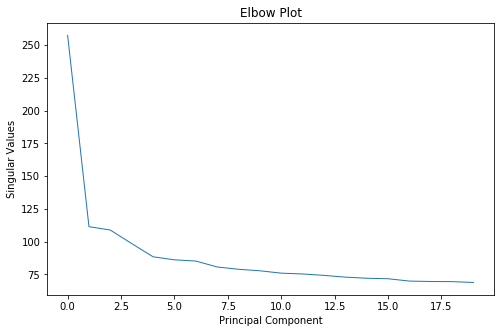

In [45]:
fig = plt.figure(figsize=(8,5))
plt.plot(S_phx_res[:20], '-', linewidth=1)
plt.title('Elbow Plot')
# plt.xticks(np.arange(0, S_phx_res.shape[0]+1, 50), rotation='vertical')
plt.xlabel('Principal Component')
plt.ylabel('Singular Values')
plt.show()

## For Restaurants in Toronto

In [46]:
U_trt_res, S_trt_res, Vt_trt_res = np.linalg.svd(sm_u_10_trt_res_train.todense())#k = min(sm_u_10_phx_res_train.shape)-1)

In [47]:
print("smallest singular value = ",min(S_trt_res))
print("largest singular value = ",max(S_trt_res))
S_trt_res_dia = np.diag(S_trt_res)

smallest singular value =  0.28742866850312165
largest singular value =  225.24596590971427


** Printing top 20 singular values**

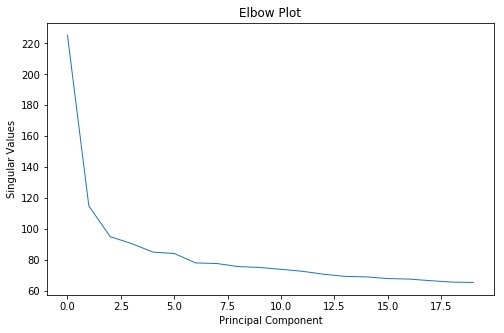

In [48]:
fig = plt.figure(figsize=(8,5))
plt.plot(S_trt_res[:20], '-', linewidth=1)
plt.title('Elbow Plot')
# plt.xticks(np.arange(0, S_phx_res.shape[0]+1, 50), rotation='vertical')
plt.xlabel('Principal Component')
plt.ylabel('Singular Values')
plt.show()

In [49]:
def approx_err(k, A, U, S, Vt):
    rec_A = np.dot(U[:, :k], np.dot(S[:k,:k], Vt[:k, :]))
    idx = np.where(A>0);
    diff = A[idx] - rec_A[idx]
    return np.linalg.norm(diff)**2/diff.shape[1]

## For Restaurants in Phoenix

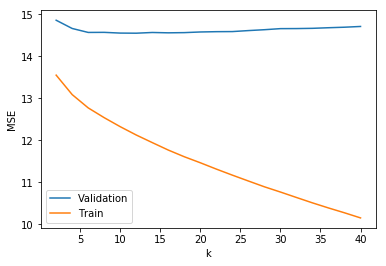

In [50]:
k = np.linspace(2,40,20, dtype = int)
errors_svd_val = {}
errors_svd_train = {}
for i in k:
    errors_svd_val[i] = approx_err(i, sm_u_10_phx_res_val.todense(), U_phx_res, S_phx_res_dia, Vt_phx_res)
    errors_svd_train[i] = approx_err(i, sm_u_10_phx_res_train.todense(), U_phx_res, S_phx_res_dia, Vt_phx_res)

plt.plot(errors_svd_val.keys(),errors_svd_val.values(), label = 'Validation')
plt.plot(errors_svd_train.keys(),errors_svd_train.values(), label = 'Train')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()

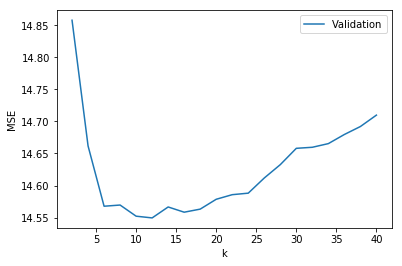

In [51]:
##Separately plotting the Validation error
plt.plot(errors_svd_val.keys(),errors_svd_val.values(), label = 'Validation')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()
plt.legend()

Text(0, 0.5, 'Principal Component 2')

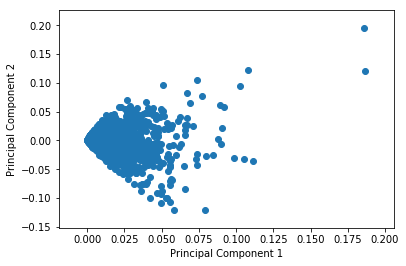

In [52]:
plt.scatter(np.ravel(U_phx_res[:,0]),np.ravel(U_phx_res[:,1]), label = 'Scatter plot for first two PCs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

Best Validation MSE for SVD

In [53]:
Best_Val_MSE_SVD_Phx = approx_err(10, sm_u_10_phx_res_val.todense(), U_phx_res, S_phx_res_dia, Vt_phx_res)
print('Best Validation MSE for SVD for Restaurants in Phoenix= ', Best_Val_MSE_SVD_Phx)

Best Validation MSE for SVD for Restaurants in Phoenix=  14.552139344346779


Non Zero Indices in Train, Val and Test

In [54]:
train_phx_nnz = sm_u_10_phx_res_train.nonzero()
val_phx_nnz = sm_u_10_phx_res_val.nonzero()
test_phx_nnz = sm_u_10_phx_res_test.nonzero()

In [55]:
recon_matrix_svd_phx = np.dot(U_phx_res[:, :10], np.dot(S_phx_res_dia[:10,:10], Vt_phx_res[:10, :]))
train_preds_svd_phx = np.ravel(recon_matrix_svd_phx[train_phx_nnz])
val_preds_svd_phx = np.ravel(recon_matrix_svd_phx[val_phx_nnz])
test_preds_svd_phx = np.ravel(recon_matrix_svd_phx[test_phx_nnz])

## For Restaurants in Toronto

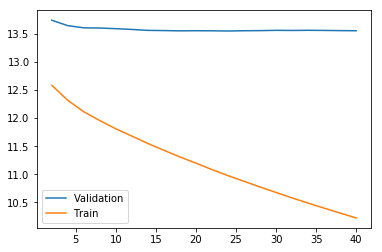

In [56]:
k = np.linspace(2,40,20, dtype = int)
errors_svd_val_trt = {}
errors_svd_train_trt = {}
for i in k:
    errors_svd_val_trt[i] = approx_err(i, sm_u_10_trt_res_val.todense(), U_trt_res, S_trt_res_dia, Vt_trt_res)
    errors_svd_train_trt[i] = approx_err(i, sm_u_10_trt_res_train.todense(), U_trt_res, S_trt_res_dia, Vt_trt_res)

plt.plot(errors_svd_val_trt.keys(),errors_svd_val_trt.values(), label = 'Validation')
plt.plot(errors_svd_train_trt.keys(),errors_svd_train_trt.values(), label = 'Train')
plt.legend()

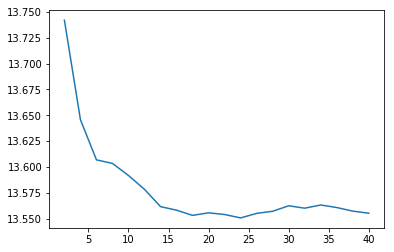

In [57]:
##Separately plotting the Validation error
plt.plot(errors_svd_val_trt.keys(),errors_svd_val_trt.values(), label = 'Validation')

Best Validation MSE for SVD

In [58]:
Best_Val_MSE_SVD_trt = approx_err(16, sm_u_10_trt_res_val.todense(), U_trt_res, S_trt_res_dia, Vt_trt_res)
print('Best Validation MSE for SVD for Restaurants in Toronto= ', Best_Val_MSE_SVD_trt)

Best Validation MSE for SVD for Restaurants in Toronto=  13.558159660843627


In [59]:
train_trt_nnz = sm_u_10_trt_res_train.nonzero()
val_trt_nnz = sm_u_10_trt_res_val.nonzero()
test_trt_nnz = sm_u_10_trt_res_test.nonzero()

In [60]:
recon_matrix_svd_trt = np.dot(U_trt_res[:, :15], np.dot(S_trt_res_dia[:15,:15], Vt_trt_res[:15, :]))
train_preds_svd_trt = np.ravel(recon_matrix_svd_trt[train_trt_nnz])
val_preds_svd_trt = np.ravel(recon_matrix_svd_trt[val_trt_nnz])
test_preds_svd_trt = np.ravel(recon_matrix_svd_trt[test_trt_nnz])

## SVD with Bias Correction

In [61]:
global_bias = np.sum(sm_u_10_phx_res_train)/sm_u_10_phx_res_train.nnz
sm_u_10_phx_res_train_wo_bias = sm_u_10_phx_res_train.todense() - global_bias
U_phx_res_wo_bias, S_phx_res_wo_bias, Vt_phx_res_wo_bias = np.linalg.svd(sm_u_10_phx_res_train_wo_bias)
print("smallest singular value = ",min(S_phx_res_wo_bias))
print("largest singular value = ",max(S_phx_res_wo_bias))
S_phx_res_dia_wo_bias = np.diag(S_phx_res_wo_bias)

smallest singular value =  6.506792200784592e-14
largest singular value =  12773.113178686026


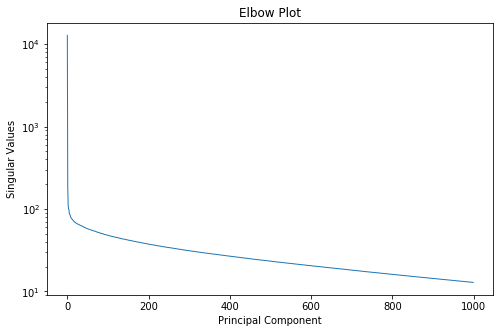

In [62]:
fig = plt.figure(figsize=(8,5))
plt.semilogy(S_phx_res_wo_bias[:1000], '-', linewidth=1)
plt.title('Elbow Plot')
plt.xlabel('Principal Component')
plt.ylabel('Singular Values')
plt.show()

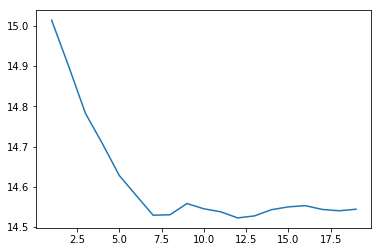

In [65]:
k_wo_bias = np.arange(1,20)
errors_svd_wo_bias = {}
sm_u_10_phx_res_val_wo_bias = sm_u_10_phx_res_val.todense() - global_bias 

for i in k_wo_bias:
    sm_u_10_phx_res_val_wo_bias_rec = np.dot(U_phx_res_wo_bias[:, :i], np.dot(S_phx_res_dia_wo_bias[:i,:i], Vt_phx_res_wo_bias[:i, :]))
    idx_wo_bias = np.where(sm_u_10_phx_res_val.todense()>0);
    diff_wo_bias = sm_u_10_phx_res_val_wo_bias[idx_wo_bias] - sm_u_10_phx_res_val_wo_bias_rec[idx_wo_bias]
    errors_svd_wo_bias[i] = np.linalg.norm(diff_wo_bias)**2/diff_wo_bias.shape[1]
plt.plot(errors_svd_wo_bias.keys(),errors_svd_wo_bias.values())

In [66]:
def find_global_user_res_bias(ratings_matrix):
    dense_matrix = ratings_matrix.todense()
    mask_matrix = (dense_matrix>0).astype(int)
    user_bias = np.sum(dense_matrix, axis = 1)/np.sum(mask_matrix, axis = 1)
    res_bias =  np.sum(dense_matrix, axis = 0)/np.sum(mask_matrix, axis = 0)
    user_bias = np.nan_to_num(user_bias)
    res_bias = np.nan_to_num(res_bias)
    user_bias = user_bias.reshape(-1,1)
    res_bias = res_bias.reshape(1,-1)
    ratings_matrix_wo_bias = dense_matrix - np.tile(user_bias, (1,dense_matrix.shape[1]))- np.tile(res_bias, (dense_matrix.shape[0], 1))
    return user_bias, res_bias, ratings_matrix_wo_bias

## For Restaurants in Phoenix

In [67]:
user_bias_ur, res_bias_ur, train_ur = find_global_user_res_bias(sm_u_10_phx_res_train)

C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [68]:
U_phx_res_wo_bias_ur, S_phx_res_wo_bias_ur, Vt_phx_res_wo_bias_ur = np.linalg.svd(train_ur)
print("smallest singular value = ",min(S_phx_res_wo_bias_ur))
print("largest singular value = ",max(S_phx_res_wo_bias_ur))
S_phx_res_dia_wo_bias_ur = np.diag(S_phx_res_wo_bias_ur)

smallest singular value =  1.4858850581744025e-13
largest singular value =  24831.180194737466


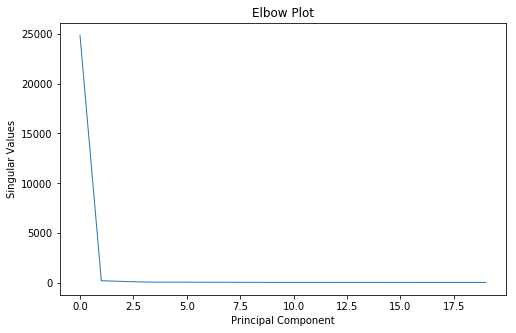

In [69]:
fig = plt.figure(figsize=(8,5))
plt.plot(S_phx_res_wo_bias_ur[:20], '-', linewidth=1)
plt.title('Elbow Plot')
plt.xlabel('Principal Component')
plt.ylabel('Singular Values')
plt.show()

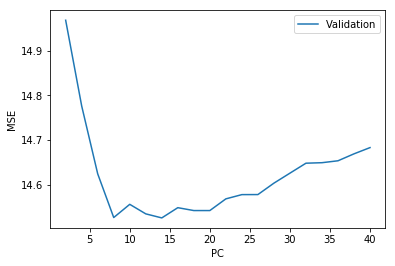

In [70]:
k_wo_bias_ur = np.linspace(2,40,20, dtype = int)
errors_svd_wo_bias_ur = {}
sm_u_10_phx_res_val_wo_bias_ur = sm_u_10_phx_res_val.todense() - user_bias_ur - res_bias_ur

for i in k_wo_bias_ur:
    sm_u_10_phx_res_val_wo_bias_ur_rec = np.dot(U_phx_res_wo_bias_ur[:, :i], np.dot(S_phx_res_dia_wo_bias_ur[:i,:i], Vt_phx_res_wo_bias_ur[:i, :]))
    idx_wo_bias_ur = np.where(sm_u_10_phx_res_val.todense()>0);
    diff_wo_bias_ur = sm_u_10_phx_res_val_wo_bias_ur[idx_wo_bias_ur] - sm_u_10_phx_res_val_wo_bias_ur_rec[idx_wo_bias_ur]
    errors_svd_wo_bias_ur[i] = np.linalg.norm(diff_wo_bias_ur)**2/diff_wo_bias_ur.shape[1]
plt.plot(errors_svd_wo_bias_ur.keys(),errors_svd_wo_bias_ur.values(), label= 'Validation')
plt.xlabel('PC')
plt.ylabel('MSE')
plt.legend()

## For Restaurants in Toronto

In [71]:
user_bias_ur_trt, res_bias_ur_trt, train_ur_trt = find_global_user_res_bias(sm_u_10_trt_res_train)

C:\Users\QuangLocLe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [72]:
U_trt_res_wo_bias_ur, S_trt_res_wo_bias_ur, Vt_trt_res_wo_bias_ur = np.linalg.svd(train_ur_trt)
print("smallest singular value = ",min(S_trt_res_wo_bias_ur))
print("largest singular value = ",max(S_trt_res_wo_bias_ur))
S_trt_res_dia_wo_bias_ur = np.diag(S_trt_res_wo_bias_ur)

smallest singular value =  0.29190962488964795
largest singular value =  34254.99542803469


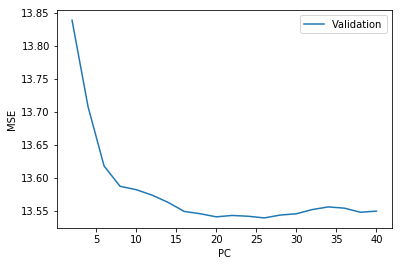

In [73]:
k_wo_bias_ur = np.linspace(2,40,20, dtype = int)
errors_svd_wo_bias_ur_trt = {}
sm_u_10_trt_res_val_wo_bias_ur = sm_u_10_trt_res_val.todense() - user_bias_ur_trt - res_bias_ur_trt

for i in k_wo_bias_ur:
    sm_u_10_trt_res_val_wo_bias_ur_rec = np.dot(U_trt_res_wo_bias_ur[:, :i], np.dot(S_trt_res_dia_wo_bias_ur[:i,:i], Vt_trt_res_wo_bias_ur[:i, :]))
    idx_wo_bias_ur_trt = np.where(sm_u_10_trt_res_val.todense()>0);
    diff_wo_bias_ur_trt = sm_u_10_trt_res_val_wo_bias_ur[idx_wo_bias_ur_trt] - sm_u_10_trt_res_val_wo_bias_ur_rec[idx_wo_bias_ur_trt]
    errors_svd_wo_bias_ur_trt[i] = np.linalg.norm(diff_wo_bias_ur_trt)**2/diff_wo_bias_ur_trt.shape[1]
plt.plot(errors_svd_wo_bias_ur_trt.keys(),errors_svd_wo_bias_ur_trt.values(), label = 'Validation')
plt.xlabel('PC')
plt.ylabel('MSE')
plt.legend()

# 3.2 Cosine Similarity with correction for bias

In [74]:
def similarity_matrix(train_matrix, between = 'users'):
    '''Returns the cosine similarity between users or restaurants'''
    if between == 'users':
        similarity = train_matrix*train_matrix.transpose()
    else:
        similarity = train_matrix.transpose()*train_matrix
    similarity_dense = similarity.todense() + 1e-8
    norm_array = np.sqrt(np.diag(similarity_dense))
    return similarity_dense/norm_array/norm_array.reshape(-1,1)

In [75]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = np.mean(ratings, axis =1)
        ratings = (ratings - np.tile(user_bias, (ratings.shape[1],1)).T).copy()
        for i in range(ratings.shape[0]):
            top_k_users = np.argsort(similarity[:,i])[:-k-1:-1]
            pred[i] = np.dot(similarity[i,top_k_users],ratings[top_k_users,:])/np.sum(np.abs(similarity[i,top_k_users]))
        pred += np.tile(user_bias,(ratings.shape[1],1)).T
    else:
        item_bias = np.mean(ratings, axis=0)
        ratings = (ratings - np.tile(item_bias,(ratings.shape[0],1))).copy()
        for j in range(ratings.shape[1]):
            top_k_items = np.argsort(similarity[:,j])[:-k-1:-1]
            pred[:,j] = np.dot(similarity[top_k_items,j].T,ratings[:,top_k_items].T)/np.sum(np.abs(similarity[top_k_items,j]))
        pred += np.tile(item_bias,(ratings.shape[0],1))
        
    return pred

In [83]:
def get_mse(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [84]:
simi_phx_res = similarity_matrix(sm_u_10_phx_res_train, between='res')
simi_phx_res = np.array(simi_phx_res)
preds_cosine_phx = predict_topk_nobias(np.array(sm_u_10_phx_res_train.todense()),simi_phx_res,kind='res', k=1)
MSE_cosine_res = get_mse(preds_cosine_phx, np.array(sm_u_10_phx_res_val.todense()))
print("MSE for cosine Similarity between Restaurants =",MSE_cosine_res)

MSE for cosine Similarity between Restaurants = 15.801775920605902


In [85]:
simi_phx_users = similarity_matrix(sm_u_10_phx_res_train, between='users')
simi_phx_users = np.array(simi_phx_users)
preds_cosine_phx_users = predict_topk_nobias(np.array(sm_u_10_phx_res_train.todense()),simi_phx_users,kind='user', k=1)
MSE_cosine_users = get_mse(preds_cosine_phx_users, np.array(sm_u_10_phx_res_val.todense()))
print("MSE for cosine Similarity between Users =",MSE_cosine_users)

MSE for cosine Similarity between Users = 15.801775920605902


## For Restaurants in Phoenix

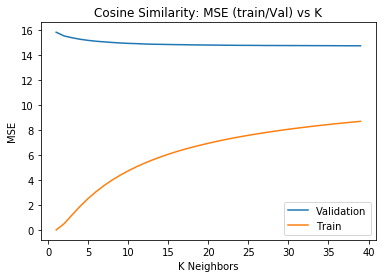

In [87]:
errors_cs_res_phx_val = {}
errors_cs_res_phx_train = {}
k_cs = np.arange(1, 40)
for i in k_cs:
    preds_cs_res_phx = predict_topk_nobias(np.array(sm_u_10_phx_res_train.todense()),simi_phx_res,kind='res', k=i)
    error_cs_val = get_mse(preds_cs_res_phx, np.array(sm_u_10_phx_res_val.todense()))
    error_cs_train = get_mse(preds_cs_res_phx, np.array(sm_u_10_phx_res_train.todense()))
    errors_cs_res_phx_val[i] = error_cs_val
    errors_cs_res_phx_train[i] = error_cs_train
plt.plot(errors_cs_res_phx_val.keys(),errors_cs_res_phx_val.values(), label = 'Validation')
plt.plot(errors_cs_res_phx_train.keys(),errors_cs_res_phx_train.values(), label = 'Train')
plt.xlabel('K Neighbors')
plt.ylabel('MSE')
plt.title('Cosine Similarity: MSE (train/Val) vs K')
plt.legend()

In [88]:
preds_cosine_phx = predict_topk_nobias(np.array(sm_u_10_phx_res_train.todense()),simi_phx_res,kind='res', k=40)
Best_Val_MSE_Cosine_phx = get_mse(preds_cosine_phx, np.array(sm_u_10_phx_res_val.todense()))
print('Best Validation MSE for Cosine Similarity for Restaurants in Phoenix= ', Best_Val_MSE_Cosine_phx)

Best Validation MSE for Cosine Similarity for Restaurants in Phoenix=  14.718224111635648


In [89]:
train_preds_cosine_phx = preds_cosine_phx[train_phx_nnz]
val_preds_cosine_phx = preds_cosine_phx[val_phx_nnz]
test_preds_cosine_phx = preds_cosine_phx[test_phx_nnz]

## For Restaurants in Toronto

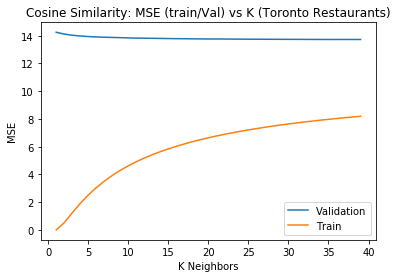

In [92]:
errors_cs_res_trt_val = {}
errors_cs_res_trt_train = {}
k_cs = np.arange(1, 40)
simi_trt_res = similarity_matrix(sm_u_10_trt_res_train, between='res')
simi_trt_res = np.array(simi_trt_res)
for i in k_cs:
    preds_cs_res_trt = predict_topk_nobias(np.array(sm_u_10_trt_res_train.todense()),simi_trt_res,kind='res', k=i)
    error_cs_val = get_mse(preds_cs_res_trt, np.array(sm_u_10_trt_res_val.todense()))
    error_cs_train = get_mse(preds_cs_res_trt, np.array(sm_u_10_trt_res_train.todense()))
    errors_cs_res_trt_val[i] = error_cs_val
    errors_cs_res_trt_train[i] = error_cs_train
plt.plot(errors_cs_res_trt_val.keys(),errors_cs_res_trt_val.values(), label = 'Validation')
plt.plot(errors_cs_res_trt_train.keys(),errors_cs_res_trt_train.values(), label = 'Train')
plt.xlabel('K Neighbors')
plt.ylabel('MSE')
plt.title('Cosine Similarity: MSE (train/Val) vs K (Toronto Restaurants)')
plt.legend()

In [93]:
preds_cosine_trt = predict_topk_nobias(np.array(sm_u_10_trt_res_train.todense()),simi_trt_res,kind='res', k=40)
Best_Val_MSE_Cosine_trt = get_mse(preds_cosine_trt, np.array(sm_u_10_trt_res_val.todense()))
print('Best Validation MSE for Cosine Similarity for Restaurants in Toronto= ', Best_Val_MSE_Cosine_trt)

Best Validation MSE for Cosine Similarity for Restaurants in Toronto=  13.722666176865024


In [94]:
train_preds_cosine_trt = preds_cosine_trt[train_trt_nnz]
val_preds_cosine_trt = preds_cosine_trt[val_trt_nnz]
test_preds_cosine_trt = preds_cosine_trt[test_trt_nnz]

# 3.3 ALS:

In [95]:
def als(ratings_matrix, k=40, user_reg=0, res_reg=0, iters=10):
    '''Performs ALS for a given ratings_matrix and returns predictions using the latent vector representation User (U x K) and Restaurant (R x K)'''
    ratings_matrix = ratings_matrix.T
    user_vec = np.random.rand(ratings_matrix.shape[1],k).T
    res_vec = np.random.rand(ratings_matrix.shape[0],k).T
    for i in range(iters):
        for u in range(ratings_matrix.shape[1]):
            user_vec[:,u] = np.linalg.solve(np.dot(res_vec,res_vec.T) + user_reg * np.eye(res_vec.shape[0]), np.dot(res_vec,ratings_matrix[:,u]))
        for r in range(ratings_matrix.shape[0]):
            res_vec[:,r] = np.linalg.solve(np.dot(user_vec,user_vec.T) + res_reg * np.eye(user_vec.shape[0]), np.dot(user_vec,ratings_matrix[r,:].T))
        prediction = np.dot(res_vec.T, user_vec)
#         error = np.mean((ratings_matrix - prediction)**2)
    return np.dot(res_vec.T, user_vec).T

## For Restaurants in Phoenix

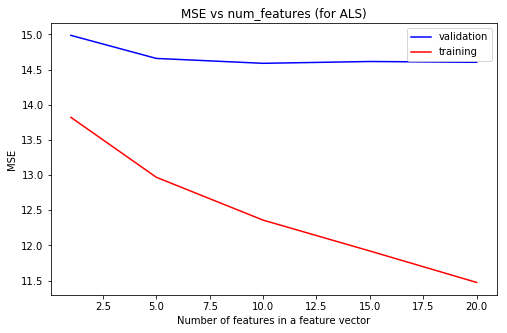

In [96]:
num_features = np.linspace(1,20,5,dtype=int)
test_error_als = []
train_error_als = []
for i in num_features:
    preds_als = als(np.array(sm_u_10_phx_res_train.todense()), k=i, iters = 5)
    test_err = get_mse(preds_als, np.array(sm_u_10_phx_res_val.todense()))
    train_err = get_mse(preds_als, np.array(sm_u_10_phx_res_train.todense()))
    test_error_als.append(test_err)
    train_error_als.append(train_err)

fig = plt.figure(figsize=(8,5))
plt.plot(num_features,test_error_als,'b-',label = 'validation')
plt.plot(num_features,train_error_als,'r-', label = 'training')
plt.title('MSE vs num_features (for ALS)')
plt.xlabel('Number of features in a feature vector')
plt.ylabel('MSE')
plt.legend()

Text(0, 0.5, 'MSE')

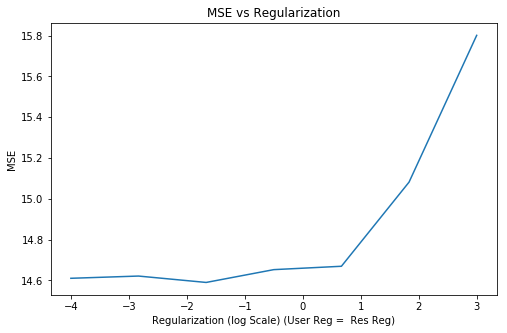

In [97]:
user_reg= np.logspace(-4,3,7)
val_error_als = {}
# train_error_als = {}
fig = plt.figure(figsize=(8,5))
for i in user_reg:
    val_error_als[i] = []
    preds_als = als(np.array(sm_u_10_phx_res_train.todense()),k=10, iters = 5, user_reg=i, res_reg=i)
    val_err = get_mse(preds_als, np.array(sm_u_10_phx_res_val.todense()))
#         train_err = get_mse(preds_als, np.array(train.todense()))
    val_error_als[i].append(val_err)
#         train_error_als[i].append(train_err)
plt.plot(np.log10(user_reg),val_error_als.values())
#     plt.plot(np.log(res_reg),train_error_als[i], label = 'User_reg = '+ str(i))


plt.title('MSE vs Regularization')
plt.xlabel('Regularization (log Scale) (User Reg =  Res Reg)')
plt.ylabel('MSE')

In [98]:
preds_als_phx = als(np.array(sm_u_10_phx_res_train.todense()),k=10, iters = 5, user_reg=0.001 , res_reg=0.001)
Best_Val_MSE_als_phx = get_mse(preds_als_phx, np.array(sm_u_10_phx_res_val.todense()))
print('Best Validation MSE for ALS for Restaurants in Phoenix= ', Best_Val_MSE_als_phx)

Best Validation MSE for ALS for Restaurants in Phoenix=  14.579539491014932


In [99]:
train_preds_als_phx = preds_als_phx[train_phx_nnz]
val_preds_als_phx = preds_als_phx[val_phx_nnz]
test_preds_als_phx = preds_als_phx[test_phx_nnz]

## For Restaurants in Toronto

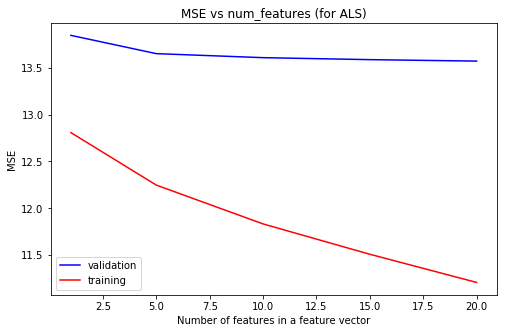

In [100]:
num_features = np.linspace(1,20,5,dtype=int)
test_error_als_trt = []
train_error_als_trt = []
for i in num_features:
    preds_als = als(np.array(sm_u_10_trt_res_train.todense()), k=i, iters = 5)
    test_err = get_mse(preds_als, np.array(sm_u_10_trt_res_val.todense()))
    train_err = get_mse(preds_als, np.array(sm_u_10_trt_res_train.todense()))
    test_error_als_trt.append(test_err)
    train_error_als_trt.append(train_err)

fig = plt.figure(figsize=(8,5))
plt.plot(num_features,test_error_als_trt,'b-',label = 'validation')
plt.plot(num_features,train_error_als_trt,'r-', label = 'training')
plt.title('MSE vs num_features (for ALS)')
plt.xlabel('Number of features in a feature vector')
plt.ylabel('MSE')
plt.legend()

Text(0, 0.5, 'MSE')

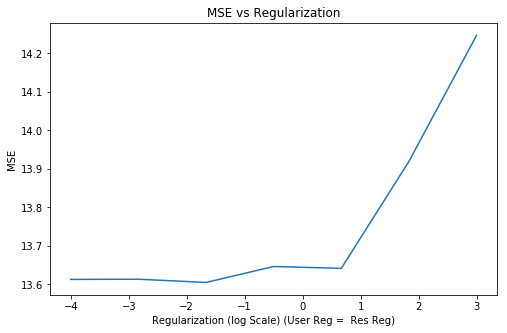

In [101]:
user_reg= np.logspace(-4,3,7)
val_error_als = {}
# train_error_als = {}
fig = plt.figure(figsize=(8,5))
for i in user_reg:
    val_error_als[i] = []
    preds_als = als(np.array(sm_u_10_trt_res_train.todense()),k=10, iters = 5, user_reg=i, res_reg=i)
    val_err = get_mse(preds_als, np.array(sm_u_10_trt_res_val.todense()))
#         train_err = get_mse(preds_als, np.array(train.todense()))
    val_error_als[i].append(val_err)
#         train_error_als[i].append(train_err)
plt.plot(np.log10(user_reg),val_error_als.values())
#     plt.plot(np.log(res_reg),train_error_als[i], label = 'User_reg = '+ str(i))


plt.title('MSE vs Regularization')
plt.xlabel('Regularization (log Scale) (User Reg =  Res Reg)')
plt.ylabel('MSE')

In [102]:
preds_als_trt = als(np.array(sm_u_10_trt_res_train.todense()),k=10, iters = 5, user_reg=0.01, res_reg=0.01)
Best_Val_MSE_als_trt = get_mse(preds_als_trt, np.array(sm_u_10_trt_res_val.todense()))
print('Best Validation MSE for ALS for Restaurants in Toronto= ', Best_Val_MSE_als_trt)

Best Validation MSE for ALS for Restaurants in Toronto=  13.595104715581751


In [103]:
train_preds_als_trt = preds_als_trt[train_trt_nnz]
val_preds_als_trt = preds_als_trt[val_trt_nnz]
test_preds_als_trt = preds_als_trt[test_trt_nnz]

# 3.4 SGD with bias correction

In [104]:
def sgd(ratings, k=40, user_bias_reg = 0.01, res_bias_reg = 0.01, user_vec_reg = 0.01, res_vec_reg = 0.01, lr = 1e-3, 
       iterations = 200):
    '''Learn user and res biases along with latent vectors'''
    error_array = np.zeros(iterations);
    global_bias = np.mean(ratings[np.where(ratings)!=0])
    user_bias = 0.1*(2*(np.random.rand(ratings.shape[0]))-1)
    res_bias = 0.1*(2*(np.random.rand(ratings.shape[1]))-1)
    user_vec = 0.1*(2*(np.random.rand(ratings.shape[0],k))-1)
    res_vec = 0.1*(2*(np.random.rand(ratings.shape[1],k))-1)
    training_idx = np.arange(ratings.nonzero()[0].shape[0])
    np.random.shuffle(training_idx)
    nz_rows_idx = ratings.nonzero()[0]
    nz_cols_idx = ratings.nonzero()[1]
    for i in range(iterations):
    
#         if(i%20 == 0):
#             print('Iteration number: ', i)
        lr = 1.0/(100 + 0.01*i)
        np.random.shuffle(training_idx)
        
        temp_error_array = np.zeros(len(training_idx));
        for datapoint_i, idx in enumerate(training_idx):
            u = nz_rows_idx[idx]
            r = nz_cols_idx[idx]
            prediction = global_bias + user_bias[u] + res_bias[r] + np.dot(user_vec[u,:], res_vec[r,:].T)
            e = (ratings[u,r] - prediction);
            temp_error_array[datapoint_i] += e**2;
            if i > 0:
                user_bias[u] += lr * (e - user_bias_reg * user_bias[u])
                res_bias[r] += lr * (e - res_bias_reg * res_bias[r])
                user_vec[u,:] += lr * (e * res_vec[r,:] - user_vec_reg * user_vec[u,:])
                res_vec[r,:] += lr * (e * user_vec[u,:] - res_vec_reg * res_vec[r,:])
            
        error_array[i] = np.mean(temp_error_array);
#         print(error_array[i])
            
    predictions = global_bias + user_bias[:, np.newaxis] + res_bias[np.newaxis, :] + np.dot(user_vec, res_vec.T)
    predictions[predictions > 5] = 5
    predictions[predictions < 0] = 0
    
    return (predictions, error_array, user_vec, res_vec)

## Tuning the Iters hyper-parameter

## For Restaurants in Toronto

iters =  10
iters =  20
iters =  30
iters =  40


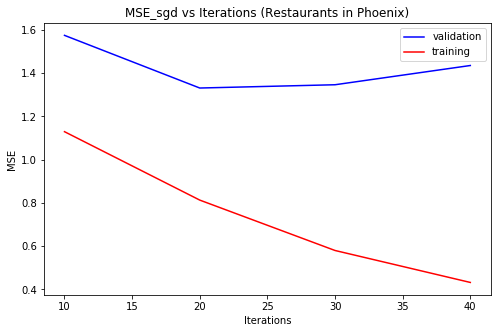

In [105]:
iters = np.arange(10, 50, 10)
err_sgd_test = []
err_sgd_train = []
for i in iters:
    print('iters = ',i)
    preds_sgd = sgd(np.array(sm_u_10_phx_res_train.todense()), k=10, iterations= i)
    err_test = get_mse(preds_sgd[0], np.array(sm_u_10_phx_res_val.todense()))
    err_train = get_mse(preds_sgd[0], np.array(sm_u_10_phx_res_train.todense()))
    err_sgd_test.append(err_test)
    err_sgd_train.append(err_train)
fig = plt.figure(figsize=(8,5))
plt.plot(iters,err_sgd_test,'b-',label = 'validation')
plt.plot(iters,err_sgd_train,'r-', label = 'training')
plt.title('MSE_sgd vs Iterations (Restaurants in Phoenix)')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()

Optimal Number of Iterations = 20

k =  2
k =  3
k =  4
k =  6
k =  7
k =  9
k =  10
k =  12
k =  13
k =  15


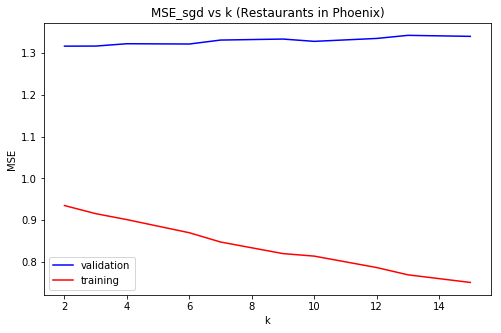

In [106]:
k = np.linspace(2, 15, 10, dtype = int)
err_sgd_test = []
err_sgd_train = []
for i in k:
    print('k = ', i)
    preds_sgd = sgd(np.array(sm_u_10_phx_res_train.todense()), k=i, iterations= 20)
    err_test = get_mse(preds_sgd[0], np.array(sm_u_10_phx_res_val.todense()))
    err_train = get_mse(preds_sgd[0], np.array(sm_u_10_phx_res_train.todense()))
    err_sgd_test.append(err_test)
    err_sgd_train.append(err_train)
fig = plt.figure(figsize=(8,5))
plt.plot(k,err_sgd_test,'b-',label = 'validation')
plt.plot(k,err_sgd_train,'r-', label = 'training')
plt.title('MSE_sgd vs k (Restaurants in Phoenix)')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()

Optimal K value = 2

In [107]:
predictions_sgd_phx, error_array_sgd_phx, user_vec_sgd_phx, res_vec_sgd_phx = sgd(np.array(sm_u_10_phx_res_train.todense()), k=2, iterations= 20)

In [108]:
preds_sgd_phx = sgd(np.array(sm_u_10_phx_res_train.todense()),k=2, iterations= 20)
Best_Val_MSE_sgd_phx = get_mse(preds_sgd_phx[0], np.array(sm_u_10_phx_res_val.todense()))
print('Best Validation MSE for SGD for Restaurants in Phoenix= ', Best_Val_MSE_sgd_phx)

Best Validation MSE for SGD for Restaurants in Phoenix=  1.3139447188359819


In [109]:
train_preds_sgd_phx = preds_sgd_phx[0][train_phx_nnz]
val_preds_sgd_phx = preds_sgd_phx[0][val_phx_nnz]
test_preds_sgd_phx = preds_sgd_phx[0][test_phx_nnz]

## For Restaurants in Toronto

iters =  10
iters =  20
iters =  30
iters =  40


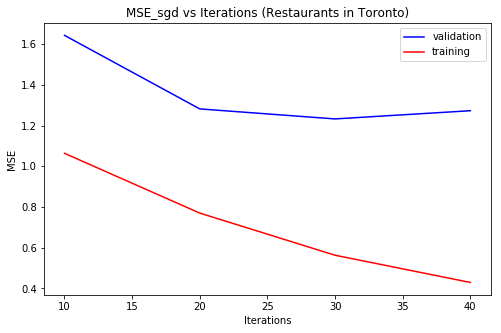

In [110]:
iters = np.arange(10, 50, 10)
err_sgd_test_trt = []
err_sgd_train_trt = []
for i in iters:
    print('iters = ',i)
    preds_sgd = sgd(np.array(sm_u_10_trt_res_train.todense()), k=10, iterations= i)
    err_test = get_mse(preds_sgd[0], np.array(sm_u_10_trt_res_val.todense()))
    err_train = get_mse(preds_sgd[0], np.array(sm_u_10_trt_res_train.todense()))
    err_sgd_test_trt.append(err_test)
    err_sgd_train_trt.append(err_train)
fig = plt.figure(figsize=(8,5))
plt.plot(iters,err_sgd_test_trt,'b-',label = 'validation')
plt.plot(iters,err_sgd_train_trt,'r-', label = 'training')
plt.title('MSE_sgd vs Iterations (Restaurants in Toronto)')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()

Optimal Number of Iterations = 30

k= 2
k= 3
k= 4
k= 6
k= 7
k= 9
k= 10
k= 12
k= 13
k= 15


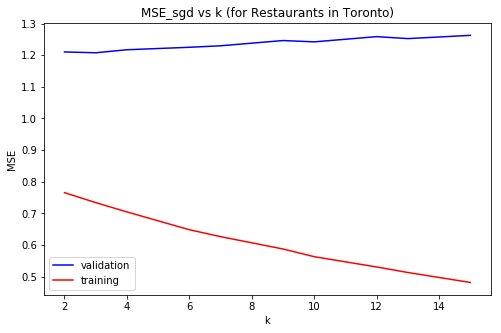

In [111]:
k = np.linspace(2, 15, 10, dtype = int)
err_sgd_val_trt = []
err_sgd_train_trt = []
for i in k:
    print('k=', i)
    preds_sgd = sgd(np.array(sm_u_10_trt_res_train.todense()), k=i, iterations= 30)
    err_val = get_mse(preds_sgd[0], np.array(sm_u_10_trt_res_val.todense()))
    err_train = get_mse(preds_sgd[0], np.array(sm_u_10_trt_res_train.todense()))
    err_sgd_val_trt.append(err_val)
    err_sgd_train_trt.append(err_train)
fig = plt.figure(figsize=(8,5))
plt.plot(k,err_sgd_val_trt,'b-',label = 'validation')
plt.plot(k,err_sgd_train_trt,'r-', label = 'training')
plt.title('MSE_sgd vs k (for Restaurants in Toronto)')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()

Optimal k value = 2

In [112]:
predictions_sgd_trt, error_array_sgd_trt, user_vec_sgd_trt, res_vec_sgd_trt = sgd(np.array(sm_u_10_trt_res_train.todense()), k=2, iterations= 30)

In [113]:
preds_sgd_trt = sgd(np.array(sm_u_10_trt_res_train.todense()),k=2, iterations=30)
Best_Val_MSE_sgd_trt = get_mse(preds_sgd_trt[0], np.array(sm_u_10_trt_res_val.todense()))
print('Best Validation MSE for SGD for Restaurants in Toronto= ', Best_Val_MSE_sgd_trt)

Best Validation MSE for SGD for Restaurants in Toronto=  1.2013173031909032


In [114]:
train_preds_sgd_trt = preds_sgd_trt[0][train_trt_nnz]
val_preds_sgd_trt = preds_sgd_trt[0][val_trt_nnz]
test_preds_sgd_trt = preds_sgd_trt[0][test_trt_nnz]

## Converting the Matrix Completion Problem into a Regression Problem

In [115]:
import pickle
def concatenated_SGD(U, V, matrix):
    '''Concatenates the User Vector U (n_u x k) and Res Vector V (n_r x K) and returns a matrix of \ 
    2k+1 x number of non-zero ratings in rating matrix (matrix)'''
    indexes=matrix.nonzero()
    users=U[indexes[0]]
    rest=V[indexes[1]]
    ratings=matrix[indexes].T
    concat_sgd=np.concatenate((users,rest,ratings),axis=1)
    return concat_sgd

## For Restaurants in Phoenix

In [116]:
train_phx = concatenated_SGD(user_vec_sgd_phx, res_vec_sgd_phx, sm_u_10_phx_res_train)
val_phx = concatenated_SGD(user_vec_sgd_phx, res_vec_sgd_phx, sm_u_10_phx_res_val)
test_phx = concatenated_SGD(user_vec_sgd_phx, res_vec_sgd_phx, sm_u_10_phx_res_test)

## Neural Network

In [117]:
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import matplotlib.pyplot as plt
import pickle

In [118]:
train_mat_phx = np.array(train_phx)
val_mat_phx = np.array(val_phx)
test_mat_phx = np.array(test_phx)

In [119]:
x_train, y_train = train_mat_phx[:, :-1], np.ravel(train_mat_phx[:,-1])
x_val, y_val = val_mat_phx[:, :-1], np.ravel(val_mat_phx[:, -1])

In [126]:
n_iteration = 1000
plot_freq = 100
a,b = 100, 0.01
batch_size = 10207 #set to -1 for entire train set
#batch_size = 5
weight_decay = 0.1

k = x_train.shape[1]
#load objects here
max_batch_size = x_train.shape[0]
if(batch_size == -1):
    batch_size = max_batch_size
if(max_batch_size % batch_size != 0):
    no_of_batches = int(max_batch_size/batch_size)
#original code:
#assert(max_batch_size % batch_size == 0);
#no_of_batches = int(max_batch_size/batch_size);

In [127]:
def get_torch_var(x):
        return(Variable(torch.Tensor( x )))

In [137]:
def plot_loss_curve(loss_array, val_array, i):
        fig, x = plt.subplots(1,1);
        x.loglog(np.arange(i), loss_array[:i], label="train");
        x.loglog(np.arange(i), val_array[:i], label="val");
        lgd = x.legend(loc='center left', bbox_to_anchor=(1, 0.5));
        x.set_xlabel('Training Iteration (log)');
        x.set_ylabel('MSE (log)');
        x.set_title('Iteration'+str(i));
        fig.savefig('loss_curve.png', format='png', dpi=150,  bbox_extra_artists=(lgd,), bbox_inches='tight');
        fig.clear()

        fig, x = plt.subplots(1,1);
        x.semilogy(np.arange(i), loss_array[:i], label="train");
        x.semilogy(np.arange(i), val_array[:i], label="val");
        lgd = x.legend(loc='center left', bbox_to_anchor=(1, 0.5));
        x.set_xlabel('Training Iteration (linear)');
        x.set_ylabel('MSE (log)');
        x.set_title('Iteration'+str(i));
        fig.savefig('loss_curve_linear.png', format='png', dpi=150,  bbox_extra_artists=(lgd,), bbox_inches='tight');
        fig.clear()

class Net(nn.Module):

    def __init__(self, k):
        super(Net, self).__init__()
        self.k = k;
        self.linear1 = nn.Linear(k, 2, bias = True);
        self.linear2 = nn.Linear(2, 1, bias = True);

    def forward(self, x):
        l_1 = self.linear1(x);
        n_1 = F.sigmoid(l_1);
        l_2 = self.linear2(n_1);
        out = F.relu(l_2);
        return out

net = Net(k)

optimizer = optim.Adam(net.parameters(), weight_decay=weight_decay);
criterion = nn.MSELoss()

loss_array = np.zeros(n_iteration);
val_array = np.zeros(n_iteration);

for i in range(n_iteration):
#     print(i)
    lr = np.true_divide(1, a + b*i);
    optimizer.param_groups[0]['lr'] = lr;
    
    loss_array_minibatches = np.zeros(no_of_batches);
    random_indices = np.random.permutation(range(max_batch_size));
    for batch_i in range(no_of_batches):
        selected_idx = random_indices[batch_i * batch_size : (batch_i+1) * batch_size];
        input = get_torch_var( x_train[selected_idx, :] );
        target = get_torch_var( y_train[selected_idx] );
        out = net(input);
        loss = criterion(out, target);

        optimizer.zero_grad()   # zero the gradient buffers
        loss.backward()
        optimizer.step()    # Does the update

        loss_array_minibatches[batch_i] = loss.data.numpy()
    
    loss_array[i] = np.mean(loss_array_minibatches);
    val_input = get_torch_var( x_val );
    val_target = get_torch_var( y_val );
    val_out = net(val_input);
    val_loss = criterion(val_out, val_target);
    val_array[i] = val_loss.data.numpy()
    
    if(i % plot_freq == 0):
        plot_loss_curve(loss_array, val_array, i);
        plt.close('all');

In [138]:
val_err_nn = val_array[-1]
print('Validation Error for NN for Restaurants in Phoenix = ', val_err_nn)

Validation Error for NN for Restaurants in Phoenix =  1.4390361309051514


In [140]:
train_preds_nn_phx = np.ravel(net(get_torch_var(x_train)).data.numpy())
val_preds_nn_phx = np.ravel(net(get_torch_var(x_val)).data.numpy())
test_preds_nn_phx = np.ravel(net(get_torch_var(test_mat_phx[:, :-1])).data.numpy())

## For Restaurants in Toronto

In [141]:
train_trt = concatenated_SGD(user_vec_sgd_trt, res_vec_sgd_trt, sm_u_10_trt_res_train)
val_trt = concatenated_SGD(user_vec_sgd_trt, res_vec_sgd_trt, sm_u_10_trt_res_val)
test_trt = concatenated_SGD(user_vec_sgd_trt, res_vec_sgd_trt, sm_u_10_trt_res_test)

In [142]:
train_mat_trt = np.array(train_trt);
val_mat_trt = np.array(val_trt);
test_mat_trt = np.array(test_trt);

In [143]:
x_train, y_train = train_mat_trt[:, :-1], np.ravel(train_mat_trt[:,-1]);
x_val, y_val = val_mat_trt[:, :-1], np.ravel(val_mat_trt[:, -1])

In [144]:
x_train.shape

(97989, 4)

In [147]:
n_iteration = 1000;
plot_freq = 100;
a,b = 100, 0.01;
batch_size = 18902; #set to -1 for entire train set
# batch_size = 5;
weight_decay = 0.1;

k = x_train.shape[1];
#load objects here
max_batch_size = x_train.shape[0];
if(batch_size == -1):
    batch_size = max_batch_size;
if(max_batch_size % batch_size != 0):
    no_of_batches = int(max_batch_size/batch_size)

In [148]:
def get_torch_var(x):
        return(Variable(torch.Tensor( x )))

In [149]:
def plot_loss_curve(loss_array, val_array, i):
        fig, x = plt.subplots(1,1);
        x.loglog(np.arange(i), loss_array[:i], label="train");
        x.loglog(np.arange(i), val_array[:i], label="val");
        lgd = x.legend(loc='center left', bbox_to_anchor=(1, 0.5));
        x.set_xlabel('Training Iteration (log)');
        x.set_ylabel('MSE (log)');
        x.set_title('Iteration'+str(i));
        fig.savefig('loss_curve.png', format='png', dpi=150,  bbox_extra_artists=(lgd,), bbox_inches='tight');
        fig.clear()

        fig, x = plt.subplots(1,1);
        x.semilogy(np.arange(i), loss_array[:i], label="train");
        x.semilogy(np.arange(i), val_array[:i], label="val");
        lgd = x.legend(loc='center left', bbox_to_anchor=(1, 0.5));
        x.set_xlabel('Training Iteration (linear)');
        x.set_ylabel('MSE (log)');
        x.set_title('Iteration'+str(i));
        fig.savefig('loss_curve_linear.png', format='png', dpi=150,  bbox_extra_artists=(lgd,), bbox_inches='tight');
        fig.clear()

class Net(nn.Module):

    def __init__(self, k):
        super(Net, self).__init__()
        self.k = k;
        self.linear1 = nn.Linear(k, 2, bias = True);
        self.linear2 = nn.Linear(2, 1, bias = True);

    def forward(self, x):
        l_1 = self.linear1(x);
        n_1 = F.sigmoid(l_1);
        l_2 = self.linear2(n_1);
        out = F.relu(l_2);
        return out

net = Net(k)

optimizer = optim.Adam(net.parameters(), weight_decay=weight_decay);
criterion = nn.MSELoss()

loss_array = np.zeros(n_iteration);
val_array = np.zeros(n_iteration);

for i in range(n_iteration):
#     print(i)
    lr = np.true_divide(1, a + b*i);
    optimizer.param_groups[0]['lr'] = lr;
    
    loss_array_minibatches = np.zeros(no_of_batches);
    random_indices = np.random.permutation(range(max_batch_size));
    for batch_i in range(no_of_batches):
        selected_idx = random_indices[batch_i * batch_size : (batch_i+1) * batch_size];
        input = get_torch_var( x_train[selected_idx, :] );
        target = get_torch_var( y_train[selected_idx] );
        out = net(input);
        loss = criterion(out, target);

        optimizer.zero_grad()   # zero the gradient buffers
        loss.backward()
        optimizer.step()    # Does the update

        loss_array_minibatches[batch_i] = loss.data.numpy()
    
    loss_array[i] = np.mean(loss_array_minibatches);
    val_input = get_torch_var( x_val );
    val_target = get_torch_var( y_val );
    val_out = net(val_input);
    val_loss = criterion(val_out, val_target);
    val_array[i] = val_loss.data.numpy()
    
    if(i % plot_freq == 0):
        plot_loss_curve(loss_array, val_array, i);
        plt.close('all');

C:\Users\QuangLocLe\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:443: UserWarning: Using a target size (torch.Size([18902])) that is different to the input size (torch.Size([18902, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\QuangLocLe\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:443: UserWarning: Using a target size (torch.Size([8420])) that is different to the input size (torch.Size([8420, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [150]:
val_err_nn_trt = val_array[-1]
print('Validation Error for NN for Restaurants in Toronto = ', val_err_nn_trt)

Validation Error for NN for Restaurants in Toronto =  1.3424965143203735


In [152]:
train_preds_nn_trt = np.ravel(net(get_torch_var(x_train)).data.numpy())
val_preds_nn_trt = np.ravel(net(get_torch_var(x_val)).data.numpy())
test_preds_nn_trt = np.ravel(net(get_torch_var(test_mat_trt[:, :-1])).data.numpy())

## Random Forest Regressor

## For Restaurants in Phoenix

In [153]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(max_depth=5)
rf.fit(train_mat_phx[:,:4],train_mat_phx[:,4])
preds_rf_phx=rf.predict(val_mat_phx[:,:4]).reshape(-1,1)
MSE_rf_phx = get_mse(preds_rf_phx, val_mat_phx[:,4])
print('MSE for Random Forest Classifier for Restaurants in Phoenix = ', MSE_rf_phx)

C:\Users\QuangLocLe\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MSE for Random Forest Classifier for Restaurants in Phoenix =  1.4387564265574548


In [154]:
train_preds_rf_phx = rf.predict(train_mat_phx[:,:4])
val_preds_rf_phx = rf.predict(val_mat_phx[:,:4])
test_preds_rf_phx = rf.predict(test_mat_phx[:,:4])

## For Restaurants in Toronto

In [155]:
rf_trt = RandomForestRegressor(max_depth=5)
rf.fit(train_mat_trt[:,:4],train_mat_trt[:,4])
preds_rf_trt = rf.predict(val_mat_trt[:,:4]).reshape(-1,1)
MSE_rf_trt = get_mse(preds_rf_trt, val_mat_trt[:,4])
print('MSE for Random Forest Classifier for Restaurants in Phoenix = ', MSE_rf_trt)

MSE for Random Forest Classifier for Restaurants in Phoenix =  1.3277170576826147


In [156]:
train_preds_rf_trt = rf.predict(train_mat_trt[:,:4])
val_preds_rf_trt = rf.predict(val_mat_trt[:,:4])
test_preds_rf_trt = rf.predict(test_mat_trt[:,:4])

## Ensemble of all the Predictors (SVD, Cosine Model, ALS, SGD, NN, RF)

In [157]:
train_preds_svd_phx.shape

(72294,)

In [158]:
def build_ensemble_df(svd, cosine,als, sgd, nn, rf):
    df =pd.DataFrame(svd)
    df.columns = ['SVD']
    df['Cosine'] = cosine
    df['ALS'] = als
    df['SGD'] = sgd
    df['Neural_Network'] = nn
    df['Random Forest'] = rf
    return df

In [159]:
ensemble_training_phx_df = build_ensemble_df(train_preds_svd_phx,train_preds_cosine_phx, train_preds_als_phx, train_preds_sgd_phx, train_preds_nn_phx, train_preds_rf_phx)
ensemble_validation_phx_df = build_ensemble_df(val_preds_svd_phx,val_preds_cosine_phx, val_preds_als_phx, val_preds_sgd_phx, val_preds_nn_phx, val_preds_rf_phx)
ensemble_testing_phx_df = build_ensemble_df(test_preds_svd_phx,test_preds_cosine_phx, test_preds_als_phx, test_preds_sgd_phx, test_preds_nn_phx, test_preds_rf_phx)

In [160]:
y_train_phx = np.ravel(np.array(sm_u_10_phx_res_train[train_phx_nnz]))
y_val_phx = np.ravel(np.array(sm_u_10_phx_res_val[val_phx_nnz]))
y_test_phx = np.ravel(np.array(sm_u_10_phx_res_test[test_phx_nnz]))

In [161]:
ensemble_training_trt_df = build_ensemble_df(train_preds_svd_trt,train_preds_cosine_trt, train_preds_als_trt, train_preds_sgd_trt, train_preds_nn_trt, train_preds_rf_trt)
ensemble_validation_trt_df = build_ensemble_df(val_preds_svd_trt,val_preds_cosine_trt, val_preds_als_trt, val_preds_sgd_trt, val_preds_nn_trt, val_preds_rf_trt)
ensemble_testing_trt_df = build_ensemble_df(test_preds_svd_trt,test_preds_cosine_trt, test_preds_als_trt, test_preds_sgd_trt, test_preds_nn_trt, test_preds_rf_trt)

In [162]:
y_train_trt = np.ravel(np.array(sm_u_10_trt_res_train[train_trt_nnz]))
y_val_trt = np.ravel(np.array(sm_u_10_trt_res_val[val_trt_nnz]))
y_test_trt = np.ravel(np.array(sm_u_10_trt_res_test[test_trt_nnz]))

In [163]:
from sklearn.linear_model import LinearRegression

## For Restaurants in Phoenix

In [164]:
lr_phx = LinearRegression(fit_intercept=True)
lr_phx.fit(ensemble_training_phx_df.iloc[:,-3:], y_train_phx)
ensemble_val_pred_phx = lr_phx.predict(ensemble_validation_phx_df.iloc[:,-3:])
MSE_ensemble_phx = get_mse(ensemble_val_pred_phx,y_val_phx)
print('MSE of the ensemble of Models for restaurants in Phoenix = ', MSE_ensemble_phx)

MSE of the ensemble of Models for restaurants in Phoenix =  1.2784577505549033


Ridge Regression with high penalty

In [165]:
from sklearn.linear_model import Ridge
lrr_phx = Ridge(alpha = 10000)
lrr_phx.fit(ensemble_training_phx_df.iloc[:,-3:], y_train_phx)
ensemble_val_pred_phx = lrr_phx.predict(ensemble_validation_phx_df.iloc[:,-3:])
MSE_ensemble_phx = get_mse(ensemble_val_pred_phx,y_val_phx)
print('MSE of the ensemble of Models for restaurants in Phoenix = ', MSE_ensemble_phx)

MSE of the ensemble of Models for restaurants in Phoenix =  1.218527993981998


## For Restaurants in Toronto

In [166]:
lr_trt = LinearRegression(fit_intercept=True)
lr_trt.fit(ensemble_training_trt_df.iloc[:,-3:], y_train_trt)
ensemble_val_pred_trt = lr_trt.predict(ensemble_validation_trt_df.iloc[:,-3:])
MSE_ensemble_trt = get_mse(ensemble_val_pred_trt,y_val_trt)
print('MSE of the ensemble of Models for restaurants in Toronto = ', MSE_ensemble_trt)

MSE of the ensemble of Models for restaurants in Toronto =  1.2017570369730841


Ridge Regression with high penalty

In [167]:
lrr_trt = Ridge(alpha = 10000)
lrr_trt.fit(ensemble_training_trt_df.iloc[:,-3:], y_train_trt)
ensemble_val_pred_trt = lrr_trt.predict(ensemble_validation_trt_df.iloc[:,-3:])
MSE_ensemble_trt = get_mse(ensemble_val_pred_trt,y_val_trt)
print('MSE of the ensemble of Models for restaurants in Toronto = ', MSE_ensemble_trt)

MSE of the ensemble of Models for restaurants in Toronto =  1.140857971053179


# 4. Testing the best model on the test data and checking the test accuracy

## For the restaurants in Phoenix and Toronto, the best model was the ensemble model.

In [168]:
ensemble_test_pred_phx = lrr_phx.predict(ensemble_testing_phx_df.iloc[:,-3:])
MSE_test_phx = get_mse(ensemble_test_pred_phx,y_test_phx)
print('MSE of the ensemble of Models for restaurants in Phoenix (test) = ', MSE_test_phx)

MSE of the ensemble of Models for restaurants in Phoenix (test) =  1.2448959110021487


In [171]:
ensemble_test_pred_trt = lrr_trt.predict(ensemble_testing_trt_df.iloc[:,-3:])
MSE_test_trt = get_mse(ensemble_test_pred_trt,y_test_trt)
print('MSE of the ensemble of Models for restaurants in Toronto (test) = ', MSE_test_trt)

MSE of the ensemble of Models for restaurants in Toronto (test) =  1.1836608464553289
